
Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

# Goals
#### Feed in as much data as I reasonably can
Based off of the last assignment I could probably get away with 600,000-800,000 observations total.  So maybe a 600,000 train, and a 200,000 test split.  Sequential is okay for now, since random and stratified read ins didn't significantly improve things.

#### PCA testing
I want to get an idea of how much PCA can reduce my dimensionality, and maybe improve my models. This is strictly for my own knowledge.  I suspect that keeping key feature importances may be more useful than reducing dimensionality.  But we'll see.

#### Plots
1 shaply and 1 partial dependence plot.

In [1]:
#helpers I've been using
def get_Xy(df):
    target = 'Response'
    return(df.drop(columns = ['Id', target]), df[target])

def get_df(itr, size):
    '''
    itr - a pandas chunk iterator. Advise passing with a chunksize that is a multiple of 10
    size - The final size of data frame you want
    return a data frame of the passed in size
    '''
    times = int(size / itr.chunksize)
    
    chunks = []
    
    for i in range(times):
        chunks.append(itr.get_chunk())
        
    return pd.concat(chunks)

## Feed in data

In [2]:
#We are going to stick with numeric dataset for right now.
#also hard coding these variables from other notebooks.  Might be nice to do some comparisons
baseline = .00385
best_perm_xgb = .75

import pandas as pd

folder = '../../DS-Unit-2-Build/bosch-production-line-performance/'

num_iter = pd.read_csv(folder + 'train_numeric.csv', iterator = True, chunksize = 1000)

In [3]:
#this is about the max that pandas can read in without puking later on in our notebook
train = get_df(num_iter, size = 500000)
val = get_df(num_iter, size = 200000)

train.shape, val.shape

((500000, 970), (200000, 970))

In [4]:
#now lets go ahead and split these up.
X_train, y_train = get_Xy(train)
X_val, y_val = get_Xy(val)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((500000, 968), (200000, 968), (500000,), (200000,))

## Plots
We have to do this a little bit earlier than I planed due to some transformation issues with my PCA analysis.

In [5]:
#not sure if this works with the classifier model.  I get the impression it doesn't.  But 
#lets go ahead and give it a try

#I pulled these features from the last assignment, the had high importance.  Would like to
#see all of them.
features = ['L3_S38_F3960', 'L1_S24_F1846', 'L3_S38_F3956']

from xgboost import XGBRegressor
from xgboost import XGBClassifier
from pdpbox.pdp import pdp_isolate, pdp_plot
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

gb = make_pipeline(
    SimpleImputer(strategy = 'median'),
    XGBClassifier(objective = 'reg:squarederror', n_jobs = -1)
)

gb.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='reg:squarederror', random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
         verbose=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


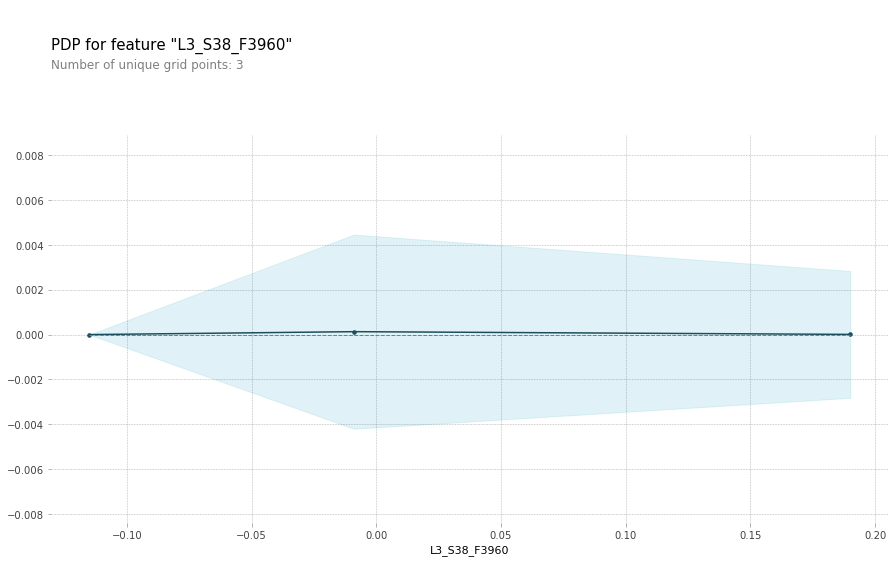

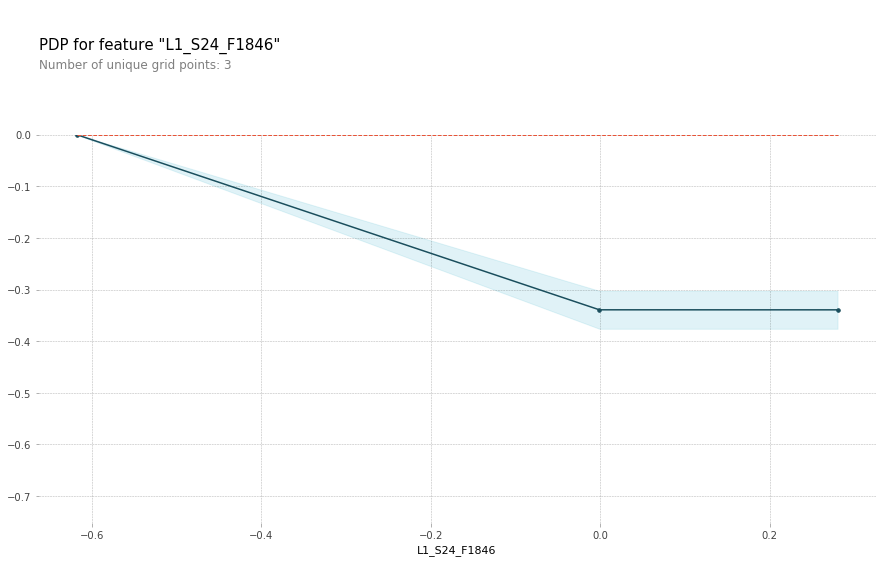

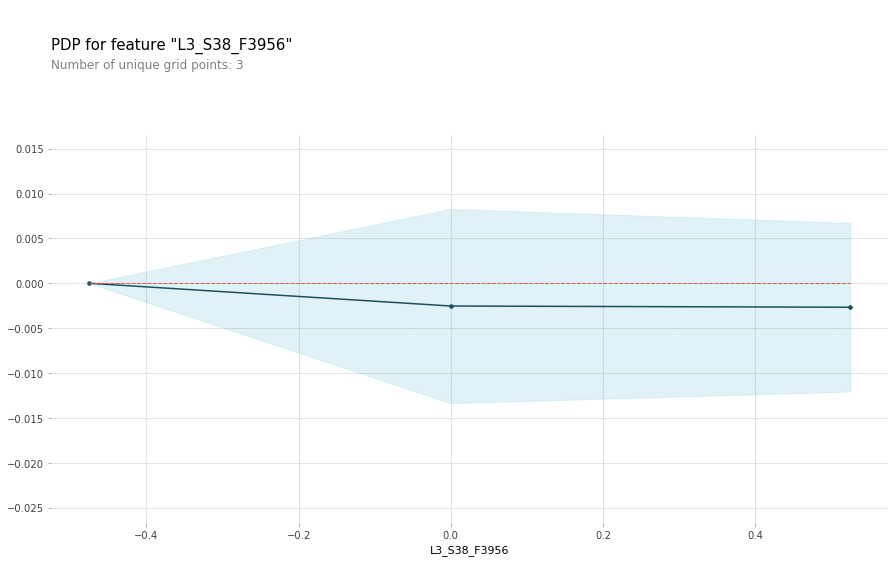

In [6]:
#runnin into issues because of nans in the validation set so manually imputing

X_val = pd.DataFrame(gb.named_steps['simpleimputer'].transform(X_val), columns = X_val.columns)

for i in range(len(features)):
    
    isolated = pdp_isolate(
        model = gb,
        dataset = X_val,
        model_features = X_val.columns,
        feature = features[i]
    )
    
    pdp_plot(isolated, feature_name = features[i]);

In [7]:
#I'm doing this really barebones.  Note to future self, look at my lesson notebook for
#better notes.

row = X_val.iloc[0]

gb.predict([row])

array([0])

In [ ]:
#okay thats a legit prediction.  Most things will be 0
import shap

#since I'm not using a decision tree, I need to use the generic  Kernel Explainer
#I just kinda hacked this with documentation.  So if this doesn't make sense to
#future me.  Well rtfm
explainer = shap.KernelExplainer(gb.named_steps['xgbclassifier'].predict,
                                 data = shap.sample(X_train, 10))
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value = explainer.expected_value,
    shap_values = shap_values,
    features = row
)

## PCA
My PCA analysis had to be moved to a new notebook.  After adding the plots above, it kept
crashing my PCA work.  See my notebook LS_DS_234_assignment_PCA.ipynb